In [1]:
from __future__ import print_function, absolute_import, division, unicode_literals
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
tf.keras.backend.set_floatx('float64')

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print(x_train.shape, x_test.shape)

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


In [3]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


In [4]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dense2 = Dense(10)
        
    def call(self, x):
      x = self.conv(x)
      x = self.flatten(x)
      x = self.dense1(x)
      return self.dense2(x)

In [5]:
model = CNN()



In [6]:
loss_fun = SparseCategoricalCrossentropy(from_logits=True)
optimizer = Adam()

In [7]:
from tensorflow.keras.metrics import Mean
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [8]:
train_loss = Mean(name='train_loss')
train_acc = SparseCategoricalAccuracy(name='train_acc')

test_loss = Mean(name='test_loss')
test_acc = SparseCategoricalAccuracy(name='test_acc')

In [9]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        pred = model(images, training=True)
        loss = loss_fun(labels, pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_acc(labels, pred)

In [10]:
@tf.function
def test_step(images, labels):
    pred = model(images, training=False)
    loss = loss_fun(labels, pred)
    
    test_loss(loss)
    test_acc(labels, pred)
    

In [11]:
epochs = 5

for epoch in range(epochs):
    train_loss.reset_states()
    train_acc.reset_states()
    
    test_loss.reset_states()
    test_acc.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
        
    for images, labels in test_ds:
        test_step(images, labels)
        
    print("Epoch: " + str(epoch + 1) + ", train_loss: " + str(train_loss.result()) + \
          ", train_acc: " + str(train_acc.result()) + ", test_loss: " + str(test_loss.result()) + \
          "test_acc: " +  str(test_acc.result()))

Epoch: 1, train_loss: tf.Tensor(0.13723924945015462, shape=(), dtype=float64), train_acc: tf.Tensor(0.9592, shape=(), dtype=float64), test_loss: tf.Tensor(0.06628193047095518, shape=(), dtype=float64)test_acc: tf.Tensor(0.9783, shape=(), dtype=float64)
Epoch: 2, train_loss: tf.Tensor(0.04629165436459395, shape=(), dtype=float64), train_acc: tf.Tensor(0.9855166666666667, shape=(), dtype=float64), test_loss: tf.Tensor(0.05572335552306568, shape=(), dtype=float64)test_acc: tf.Tensor(0.9819, shape=(), dtype=float64)
Epoch: 3, train_loss: tf.Tensor(0.02412845047668088, shape=(), dtype=float64), train_acc: tf.Tensor(0.9917166666666667, shape=(), dtype=float64), test_loss: tf.Tensor(0.054147370366060966, shape=(), dtype=float64)test_acc: tf.Tensor(0.9839, shape=(), dtype=float64)
Epoch: 4, train_loss: tf.Tensor(0.013393437640659006, shape=(), dtype=float64), train_acc: tf.Tensor(0.9955333333333334, shape=(), dtype=float64), test_loss: tf.Tensor(0.06733327207255355, shape=(), dtype=float64)tes

7


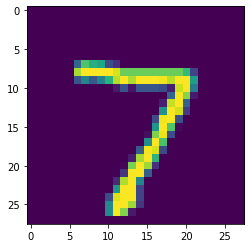

In [13]:
import matplotlib.pyplot as plt
import numpy as np

test = x_test[0][...]
test = test.reshape((28, 28))
plt.imshow(test)

test = test.reshape((1, 28, 28, 1))
print(np.argmax(model(test)))